# Surrogate Model Training

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="5"

In [3]:
torch.manual_seed(78263992)

# specify device depending on availability of GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Helper functions

In [4]:
# wraps a separated dataset to avoid issues while shuffling
class WrapperDataset(torch.utils.data.Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __getitem__(self, index):
        return self.x[index], self.y[index]

    def __len__(self):
        return len(self.y)

# get the same batch split for inputs and labels
def get_batched_x_y(x, y, batch_size, shuffle):
    dataset = WrapperDataset(x, y)
    batched = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    return batched

## Data loading

In [5]:
X_train = torch.load("X_train.pt").to_dense()
X_val = torch.load("X_val.pt").to_dense()
X_test = torch.load("X_test.pt").to_dense()
y_train = torch.load("y_train.pt")
y_val = torch.load("y_val.pt")
y_test = torch.load("y_test.pt")

In [6]:
def zeroPadInput(inputs, amount=50):
    # adds zero padding vectors to the end of each sequence
    for i in range(len(inputs)):
        zero_padding = torch.zeros(inputs[i].shape[0], amount, inputs[i].shape[2])
        inputs[i] = torch.cat([inputs[i], zero_padding], dim=1)
    return inputs

In [7]:
X_train, X_val, X_test = zeroPadInput([X_train, X_val, X_test])

## Hyperparameters

In [8]:
hidden_size = 256
lstm_layers = 2
training_epochs = 10
augmentation_epochs = 3
train_batch_size = 256
epsilon = 1e-2

In [9]:
input_size = X_train.shape[2]
sequence_size = X_train.shape[1]

## Model initialization

In [10]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, lstm_layers, pooling):
        super(Net, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, lstm_layers, batch_first=True)
        self.pool = pooling(sequence_size)
        self.linear = nn.Linear(hidden_size, 1)

    def forward(self, x):
        lstm_out = self.lstm(x)[0]
        pool_out = self.pool(lstm_out.permute(0, 2, 1))
        linear_out = self.linear(pool_out.squeeze())
        return torch.squeeze(linear_out)

In [11]:
def predict(x, model):
    myX = x.to(device)
    output = model(myX)
    return output > 0

In [12]:
def predictProbability(x, model):
    myModel = model.to("cpu")
    output = model(x)
    return torch.sigmoid(output).data

In [13]:
def initModel(input_size, hidden_size, lstm_layers, pooling):
    model = Net(input_size, hidden_size, lstm_layers, pooling)
    model.to(device)
    return model
surrogateModel = initModel(input_size, hidden_size, lstm_layers, nn.MaxPool1d)
surrogateModel

Net(
  (lstm): LSTM(264, 256, num_layers=2, batch_first=True)
  (pool): MaxPool1d(kernel_size=150, stride=150, padding=0, dilation=1, ceil_mode=False)
  (linear): Linear(in_features=256, out_features=1, bias=True)
)

In [14]:
blackBoxModel = initModel(input_size, 128, 1, nn.MaxPool1d)
blackBoxModel.load_state_dict(torch.load("final-lstm-model.pt"))
blackBoxModel

Net(
  (lstm): LSTM(264, 128, batch_first=True)
  (pool): MaxPool1d(kernel_size=150, stride=150, padding=0, dilation=1, ceil_mode=False)
  (linear): Linear(in_features=128, out_features=1, bias=True)
)

## Training procedures

In [15]:
def train(x, y, model, epochs, batch_size, loss_function, optimizer):
    for epoch in range(epochs):
        print("Training Epoch", epoch)
        # shuffle and batch the data set
        batched = get_batched_x_y(x, y, batch_size, True)
        for xi, yi in batched:
            # move data to device
            xi = xi.to(device)
            yi = yi.to(device)
            # reset previous gradients
            optimizer.zero_grad()
            # forward pass through model
            output = model(xi)
            # calculate current loss of model
            loss = loss_function(output, yi)
            # backprop
            loss.backward()
            # take optimization step
            optimizer.step()

In [16]:
def jacobianAugmentationTraining(blackBoxModel, surrogateModel, training_epochs, augmentation_epochs, xInit,
                                 epsilon, batch_size, loss_function, optimizer):
    x = xInit
    for epoch in range(augmentation_epochs):
        print("Augmentation Epoch", epoch)
        # get labels from black box model
        y = predictProbability(x, blackBoxModel)
        # train surrogate model on dataset labeled by black box model
        train(x, y, surrogateModel, training_epochs, batch_size, loss_function, optimizer)
        # skip augmentation after last training
        if epoch == augmentation_epochs - 1:
            break
        # augment dataset with jacobian
        batched = get_batched_x_y(x, y, 128, False)
        for xi, yi in batched:
            xi = xi.to(device)
            # get jacobian of surrogate model
            jacobian = torch.diagonal(torch.autograd.functional.jacobian(surrogateModel.forward, xi)).permute(2, 0, 1)
            # create new samples
            newX = xi + epsilon * torch.sign(jacobian)
            # append new samples
            x = torch.cat([x, newX.data.cpu()])
            print("input shape", x.shape)

## Training

In [17]:
def getWeightedBCE():
    negative_samples = (y_val == 0).sum()
    positive_samples = (y_val == 1).sum()
    return nn.BCEWithLogitsLoss(pos_weight=negative_samples/positive_samples)

In [18]:
loss_function = getWeightedBCE()
optimizer = torch.optim.Adam(surrogateModel.parameters())

In [19]:
jacobianAugmentationTraining(blackBoxModel, surrogateModel, training_epochs, augmentation_epochs, X_val, epsilon,
                             train_batch_size, loss_function, optimizer)

Augmentation Epoch 0
Training Epoch 0
Training Epoch 1
Training Epoch 2
Training Epoch 3
Training Epoch 4
Training Epoch 5
Training Epoch 6
Training Epoch 7
Training Epoch 8
Training Epoch 9
input shape torch.Size([4516, 150, 264])
input shape torch.Size([4644, 150, 264])
input shape torch.Size([4772, 150, 264])
input shape torch.Size([4900, 150, 264])
input shape torch.Size([5028, 150, 264])
input shape torch.Size([5156, 150, 264])
input shape torch.Size([5284, 150, 264])
input shape torch.Size([5412, 150, 264])
input shape torch.Size([5540, 150, 264])
input shape torch.Size([5668, 150, 264])
input shape torch.Size([5796, 150, 264])
input shape torch.Size([5924, 150, 264])
input shape torch.Size([6052, 150, 264])
input shape torch.Size([6180, 150, 264])
input shape torch.Size([6308, 150, 264])
input shape torch.Size([6436, 150, 264])
input shape torch.Size([6564, 150, 264])
input shape torch.Size([6692, 150, 264])
input shape torch.Size([6820, 150, 264])
input shape torch.Size([6948, 

## Saving model

In [25]:
torch.save(surrogateModel.state_dict(), "surrogate-model.pt")

## Testing

In [17]:
surrogateModel.load_state_dict(torch.load("surrogate-model.pt"))

<All keys matched successfully>

In [18]:
blackBoxPredictions = predictProbability(X_test, blackBoxModel)
surrogatePredictions = predictProbability(X_test, surrogateModel)
difference = blackBoxPredictions - surrogatePredictions

In [19]:
matches = (surrogatePredictions > 0.5) == y_test
sensitivity = matches[y_test == 1].sum() / (y_test == 1).sum()
specificity = matches[y_test == 0].sum() / (y_test == 0).sum()
print("Sensitivity", sensitivity.item(), "Specificity", specificity.item())

Sensitivity 0.8593457937240601 Specificity 0.9722222089767456


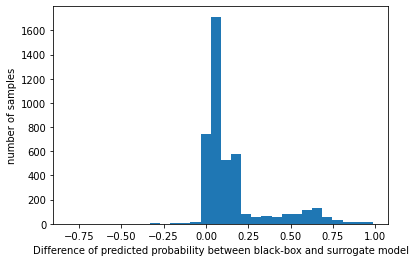

In [20]:
import matplotlib.pyplot as plt
plt.hist(difference.numpy(), bins=30)
plt.xlabel("Difference of predicted probability between black-box and surrogate model")
plt.ylabel("number of samples")
plt.show()

In [21]:
blackBoxPredictions = predictProbability(X_val, blackBoxModel)
surrogatePredictions = predictProbability(X_val, surrogateModel)
difference = blackBoxPredictions - surrogatePredictions

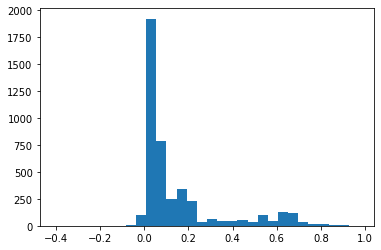

In [22]:
import matplotlib.pyplot as plt
plt.hist(difference.numpy(), bins=30)
plt.show()